In [1]:
import numpy as np
import snap
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

### 加载数据

# of Nodes 1589
# of Edges 2742


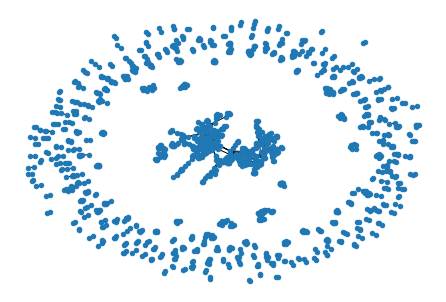

In [3]:
G=snap.TUNGraph.Load(snap.TFIn('hw1-q2.graph'))
print("# of Nodes",G.GetNodes())
print("# of Edges",G.GetEdges())
def draw(G):
    HG=nx.Graph()
    for e in G.Edges():
        HG.add_edge(e.GetSrcNId(),e.GetDstNId())
    pos=nx.spring_layout(HG,seed=0)
    nx.draw(HG,pos,node_size=20)
draw(G)

In [7]:
def vec2Numpy(v):
    r=np.empty(shape=(v.Len(),))
    for i,x in enumerate(v):r[i]=x
    return r
def similar(feature,target):
    
    n1=np.linalg.norm(feature,axis=1)
    mask=np.where(n1==0)[0]
    n1[mask]=1
    
    n2=np.linalg.norm(target)
    assert n2>0
    result=feature.dot(target)/n1/n2
    #防止属性全为0的情况
    mask=np.where(n1==0)[0]
    result[mask]=0
    return result


def topKSimilar(feature,targetIndex,K):
    score=similar(feature,feature[targetIndex])
    rank=np.argsort(-score)[1:K+1]
    score=score[rank]
    return rank,score

### 特征统计
* 每个顶点的度
* 每个顶点egonet的边
* 每个顶点egonet的对外边

In [8]:
def getDegree(G):
    v=snap.TIntV()
    snap.GetDegSeqV(G,v)
    return vec2Numpy(v)[:,np.newaxis]
def getEgonetFeature(G):
    egonet_features=np.empty(shape=(G.GetNodes(),2));
    for i,node in enumerate(G.Nodes()):
        neighbours=snap.TIntV()
        degree=node.GetDeg()
        for cn in range(degree):
            nid=node.GetNbrNId(cn)
            neighbours.Add(nid)
        neighbours.Add(node.GetId())
        egonet_features[i]=snap.GetEdgesInOut(G,neighbours)
    return egonet_features
def extreactBaseFeature(G):
    f1=getDegree(G)
    f23=getEgonetFeature(G)
    feature=np.concatenate((f1,f23),axis=1)
    return feature
def get_neibour(G,t):
    '''
        打印一个节点ID=t的邻居
    '''
    n=G.GetNI(t)
    deg=n.GetDeg()
    nei=[n.GetNbrNId(i) for i in range(deg)]
    return nei

In [6]:
basefeature=extreactBaseFeature(G)
se,score=topKSimilar(basefeature,9,5)
drawSubGraph(G,9,hop=2)
for s in se:
    drawSubGraph(G,int(s),hop=2)

NameError: name 'drawSubGraph' is not defined

#### 测试代码
* 测试提取的基本特征是不是正确

In [9]:
def sanity_check_feature(feature):
    ids=np.random.choice(np.arange(len(feature)),100,False)
    ids=[1,2,3]
    for idd in ids:
        f1,f2,f3=feature[int(idd)]
        n=G.GetNI(idd)
        deg=n.GetDeg()
        
        all_node_degree=deg
        subnodes=[n.GetId()]
        for d in range(deg):
            nid=n.GetNbrNId(d)
            subnodes.append(nid)
            all_node_degree+=G.GetNI(nid).GetDeg()
        
        _f1=deg
        subgraph=snap.GetSubGraph(G,snap.TIntV.GetV(*subnodes))
        _f2=subgraph.GetEdges()
        _f3=all_node_degree-2*_f2
        
        assert _f1==f1 and _f2==f2 and _f3==f3
def print_neigh(G,t):
    '''
        打印一个节点ID=t的邻居
    '''
    nei=get_neibour(G,t)
    print("%d:"%t,nei)
sanity_check_feature(basefeature)

### 迭代特征值
$$V^{(t+1)}_v=[V_u^{(t)} \ \ \frac{1}{|N(v)|}\sum_{u \in N(v)}V_u ^{(t)}\ \ \sum_{u \in N(v)}V_u ^{(t)}]$$
* 当N(v)==0时，mean,sum项都是0

In [10]:
def recursive_feature(G,feature,K=2):
    fbase=feature.copy()
    for k in range(K):
        fmeans=np.empty_like(fbase)
        fsums=np.empty_like(fbase)
        
        for n in G.Nodes():
            neibour_feature=fbase[get_neibour(G,n.GetId())]
            if len(neibour_feature)>0:
                fmean=np.average(neibour_feature,axis=0)
                fsum=np.sum(neibour_feature,axis=0)
            else:
                fmean=np.zeros_like(fbase[0])
                fsum=np.zeros_like(fbase[0])
            fmeans[n.GetId()]=fmean
            fsums[n.GetId()]=fsum
            
        fbase=np.concatenate((fbase,fmeans,fsums),axis=1)
    return fbase

### 沙箱测试

In [11]:
def drawSubGraph(G,t,hop=2):

    NetG=nx.Graph()
    
    center=[t]
    start=0
    for _ in range(hop-1):
        _center=center[start:]
        for c in _center:
            center.extend(get_neibour(G,c))
        start+=len(_center)
    center=set(center)
    for c in center:
        adjs=get_neibour(G,c)
        for ad in adjs:
            NetG.add_edge(c,ad)
            
    pos=nx.spring_layout(NetG,seed=0)
    plt.figure(figsize=(5,5))
    nx.draw(NetG,pos,with_labels=True,label=[str(n) for n in NetG.nodes()])
    nx.draw(NetG,pos,nodelist=[t],node_color=['r'])
    plt.title('node %d and %d hop neibour'%(t,hop))

In [12]:
recur_feature=recursive_feature(G,basefeature,2)
se,score=topKSimilar(recur_feature,9,8)

0.9959848829010806
0.9946130044020561
0.9937284425239259
0.9922839741918225
0.9922413199302673
0.9922413199302673
0.9904971299996075
0.9902105236648335


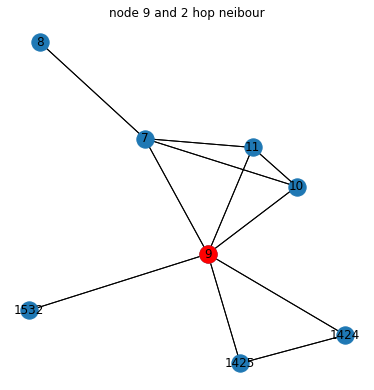

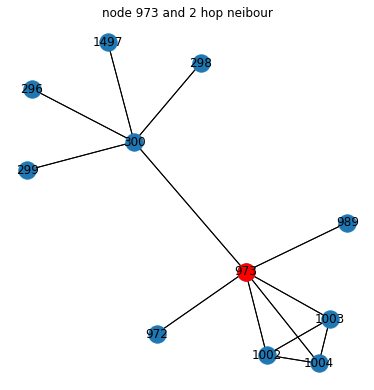

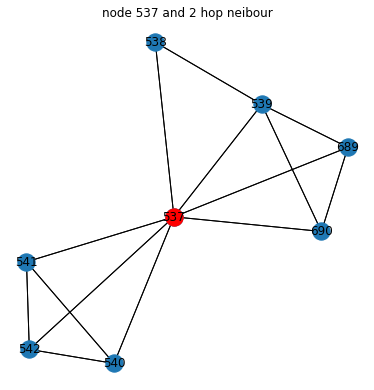

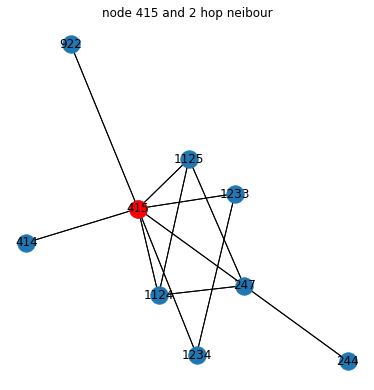

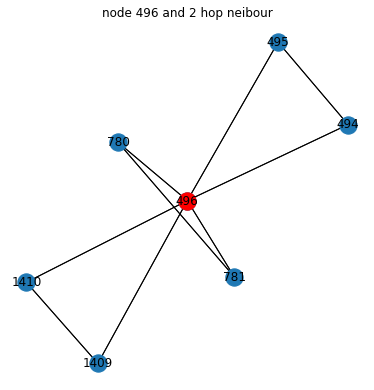

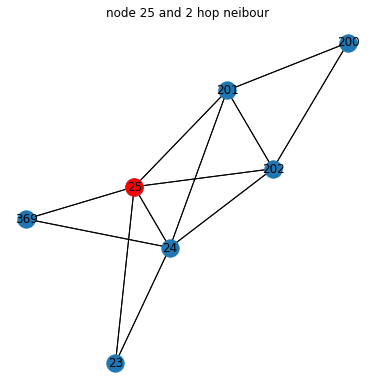

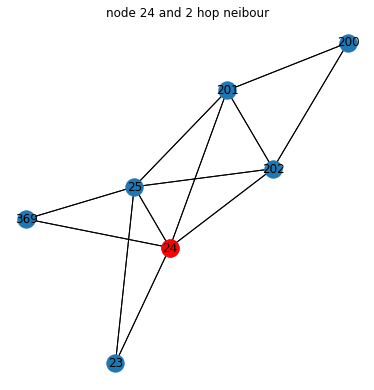

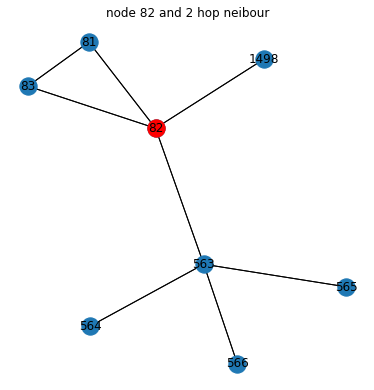

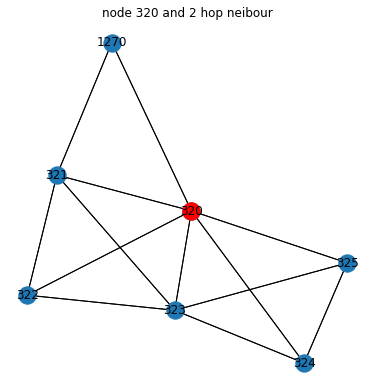

In [13]:
drawSubGraph(G,9,2)
for s,sc in zip(se,score):
    drawSubGraph(G,int(s),2)
    print(sc)

### Role Discovery

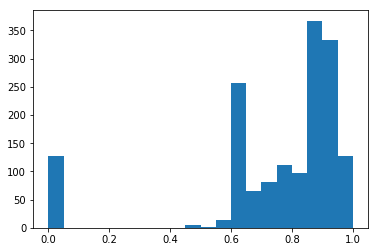

In [14]:
score_list=similar(recur_feature,recur_feature[9])
bins_count,bins_label,_=plt.hist(score_list,bins=20)

In [15]:
bins_count[12]

256.0

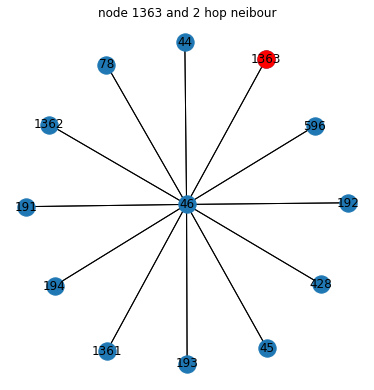

In [16]:
# np.where(score_list>=bins_label[len(bins_count)-3] score_list<=bins_label[len(bins_count)-2])
label=12
clusters=np.logical_and(score_list>=bins_label[label],score_list<=bins_label[label+1])
idd=np.where(clusters)[0]
drawSubGraph(G,int(idd[220]))

### Lanvain聚类算法

In [318]:
def get_degree(G,nodes,weight=None):
    X=G.degree(nodes,weight=weight)
    cnt=0
    for k,v in X:
        cnt+=v
    return cnt
def get_pair_weight(G,pairs,weight=None):
    if not G.has_edge(*pairs):return 0
    w=0
    for k,v in G.get_edge_data(*pairs).items():
        if weight is None:
            w+=1
        else:w+=v[weight]
    return w

class Community():
    def __init__(self,G,nodes=None,weight='weight'):
        '''
        输入G,node表示一个节点构成一个community
        
        '''
        if nodes is not None:
            self.sigma_in=2*sum([get_pair_weight(G,(nodes[i],nodes[j]),weight) 
                               for i in range(len(nodes)-1) for j in range(i+1,len(nodes))])
            self.sigma_tot=get_degree(G,nodes,weight=weight)
            self.w=self.sigma_tot-self.sigma_in
            
            self.members=nodes[:]
            self.degrees=[G.degree(n,weight=weight) for n in nodes]
            self.weight=weight
            assert self.w>=0
        self.valid=True
    def __len__(self):
        return len(self.members)
    def get_cross_node_weight(self,G,nodei):
        k_i_in=0
        for member in self.members:
            k_i_in+=2*get_pair_weight(G,(member,nodei),self.weight)
        return k_i_in
    def get_cross_weight(self,G,other):
        '''
        计算nodes的每一个节点 与本Community的权值重之和
        other如果与本Community有交集，报错
        '''
        out=0
        for n in other.members:
            out+=self.get_cross_node_weight(G,n)
        return out
    def merge(self,other,nodei,K_i_in,K_i_out):
        '''
        other's community member i request to join this community
        k_i_in 是member i与community member的成对权重之和
        '''
        i=other.members.index(nodei)
        
        self.sigma_tot+=other.degrees[i]
        self.sigma_in+=K_i_in
        
        other.sigma_tot-=other.degrees[i]
        other.sigma_in-=K_i_out
        
        self.w=self.sigma_tot-self.sigma_in
        
        assert self.w>=0
        
        self.members.append(other.members[i])
        self.degrees.append(other.degrees[i])
        other.members.pop(i)
        other.degrees.pop(i)
        

In [319]:
G=nx.MultiGraph()
G.add_edge(0,1,weight=1.2)
G.add_edge(0,2,weight=1.3)

0

In [320]:
G.degree([0,1],weight='weight')

MultiDegreeView({0: 2.5, 1: 1.2})

In [321]:
def sanity_test2():
    G=nx.MultiGraph()
    G.add_edge(0,1,weight=1.2)
    G.add_edge(0,2,weight=1.3)
    c0=Community(G,[0])
    c1=Community(G,[1])
    c2=Community(G,[2])
    
    
    assert c0.sigma_tot==2.5
    assert c0.sigma_in==0
    assert c0.w==2.5
    
    c12=Community(G,[1,2])
    assert c12.sigma_tot==2.5
    assert c12.sigma_in==0
    assert c12.w==2.5
    
    
    c01=Community(G,[0,1])
    assert c01.sigma_tot==3.7
    assert c01.sigma_in==2.4
    
    c02=Community(G,[0,2])
    assert c02.sigma_tot==3.8
    assert c02.sigma_in==2.6 
    
    
    r0_1=c0.get_cross_weight(G,c1)
    assert r0_1==2.4
    
    r0_2=c0.get_cross_weight(G,c2)
    assert r0_2==2.6
    
    r1_2=c1.get_cross_weight(G,c2)
    assert r1_2==0
    
    r0_12=c0.get_cross_weight(G,c12)
    assert r0_12==2.4+2.6
    
    r1_02=c1.get_cross_weight(G,c02)
    assert r1_02==2.4
    
    r2_01=c2.get_cross_weight(G,c01)
    assert r2_01==2.6
    
    out0=c0.get_cross_node_weight(G,0)
    assert out0==0
    
    out1=c01.get_cross_node_weight(G,1)
    assert out1==2.4
    
    leave_0_01=c01.get_cross_node_weight(G,0)
    assert leave_0_01==2.4
    
    enter_0_2=c2.get_cross_node_weight(G,0)
    assert enter_0_2==2.6
    
    c2.merge(c01,0,enter_0_2,leave_0_01)
    assert c2.sigma_tot==c02.sigma_tot
    assert c2.sigma_in==c02.sigma_in

    np.testing.assert_allclose(c01.sigma_tot,c1.sigma_tot,1e-5)
    np.testing.assert_allclose(c01.sigma_in,c1.sigma_in,1e-5)
    
    assert c2.members==[2,0]
    assert c2.degrees==[1.3,2.5]
    
    c0,c12
    print(delteQ(G,c12,c0,0,weight='weight'))

In [312]:
sanity_test2()

0.46875
0.78125
1.25


\begin{equation}
 \sum_{\substack{s \in C}}
 \sum_{\substack{ i,j \in s}}\frac{A_{ij}}{2m}-\frac{w_iw_j}{(2m)^2}
 \end{equation}
对于一个community:
\begin{equation}
	Q=\frac{\sum_{in}}{2m}-\frac{\sum^2_{tot}}{(2m)^2}+\frac{S^2_{in}}{(2m)^2}
\end{equation}

* $\sum_{in}$表示在本community内所有节点对的权重之和.
* $\sum^2_{tot}$表示在本community内的所有节点的权重和的平方.
* $S^2_{in}$表示在本community内内的所有节点的权重平方和。
\begin{equation}
	Q(i \to C)=\frac{\sum_{in}+k_{i,in}}{2m}-\frac{(\sum_{tot}+k_i)^2}{(2m)^2}+\frac{S^2_{in}+k^2_i}{(2m)^2} \\
	\Delta Q(i \to C)=\left[\frac{\sum_{in}+k_{i,in}}{2m}-\frac{\sum_{in}}{2m}\right]-\left[\frac{(\sum_{tot}+k_i)^2}{(2m)^2}-\frac{\sum_{tot}^2}{(2m)^2}\right]+\left[\frac{S^2_{in}+k^2_i}{(2m)^2}-\frac{S^2_{in}}{(2m)^2}\right]\\
	=\left[\frac{\sum_{in}+k_{i,in}}{2m}-\frac{\sum_{in}}{2m}\right]-\left[\frac{(\sum_{tot}+k_i)^2}{(2m)^2}-\frac{\sum_{tot}^2}{(2m)^2}\right]+\left[\frac{k^2_i}{(2m)^2}\right]\\
    =\frac{k_{i,in}}{2m}-\frac{2k_i\sum_{tot}}{(2m)^2}
\end{equation}


In [348]:
def modularity(G,i,C,weight='weight'):
    '''
    i
    C
    '''
    m_2=2*len(G.edges())
    
    k_i_in=C.get_cross_node_weight(G,i)
    sigma_tot=C.sigma_tot
    ki=G.degree(i,weight=weight)
    
    r=k_i_in/m_2-(2*ki*sigma_tot)/(m_2**2)
    return r
def delteQ(G,C_enter,C_leave,nodei,weight='weight'):
    '''
    C_leave 的node i申请离开C_leave进入C_enter
    '''
    a=modularity(G,nodei,C_enter,weight)
    assert nodei in C_leave.members
    if len(C_leave)==1:
        b=0
    else:
        b=-modularity(G,nodei,C_leave,weight)
    return a+b

In [349]:
c0=Community(G,[0])
c12=Community(G,[1,2])

In [350]:
modularity(G,0,c0)

-0.78125

In [353]:
delteQ(G,c12,c0,0)

0.46875